# ARIMA model-demo practice-Electric Prodction

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [2]:
import os
working_directory = os.getcwd()
print(working_directory)

/Users/odile


## Prepare the data as two parts for "training" and "testing" use

In [61]:
#index_col=0, parse_dates=[0]
path ='Electric_Production.csv'
ElectricProduction = pd.read_csv(path, index_col = 'DATE', parse_dates=['DATE'])

#check dataframe
print(ElectricProduction.head())

ElectricProduction.index = pd.to_datetime(ElectricProduction.index)
data_EP = ElectricProduction['1985':'2018']['IPG2211A2N']
train = data_EP.loc['1985':'2014']
test = data_EP.loc['2014':'2018']
print(train.head())

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2014-08-01    108.1940
2014-09-01    100.4172
2014-10-01     92.3837
2014-11-01     99.7033
2014-12-01    109.3477
Name: IPG2211A2N, Length: 360, dtype: float64


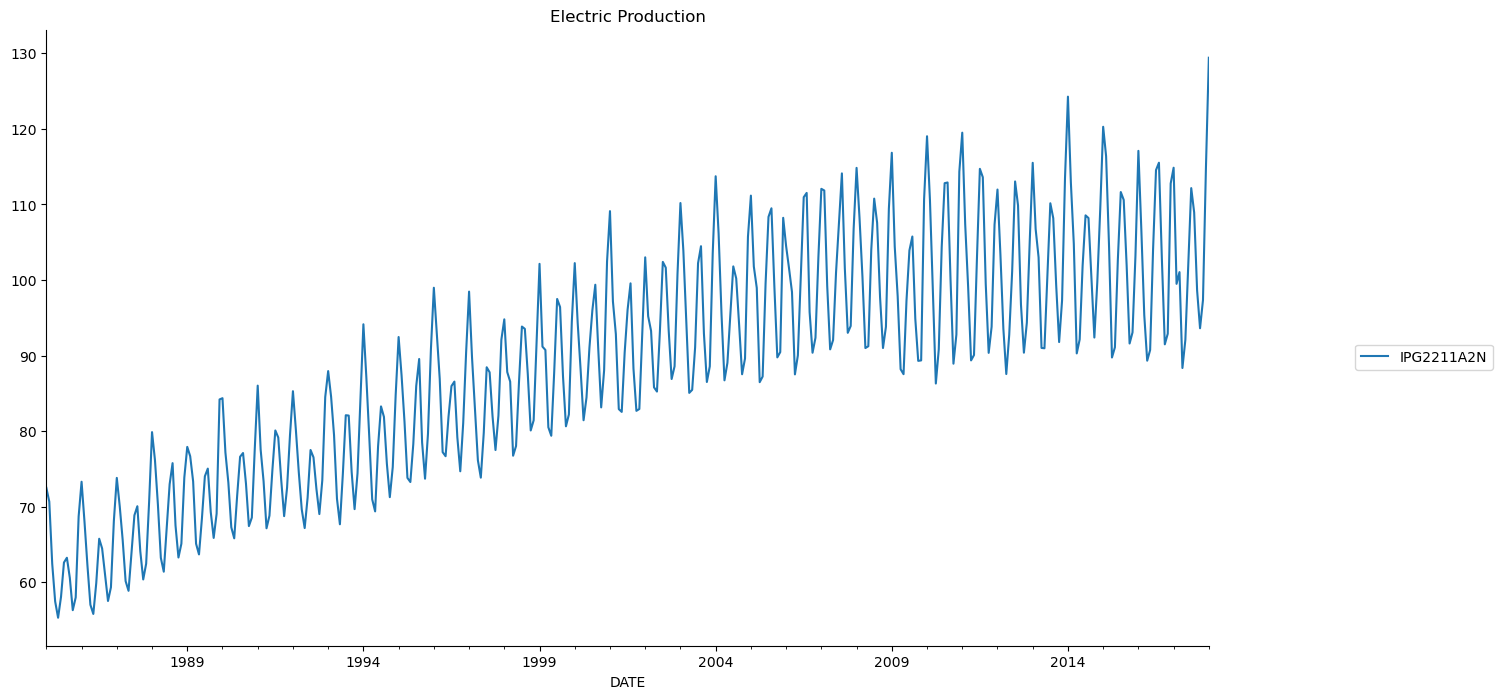

In [4]:
#plot line chart for this whole database by date in x-axis
ElectricProduction = ElectricProduction.loc['1985':'2018']
ElectricProduction.plot(figsize = (15,8))
plt.title('Electric Production')
plt.legend(bbox_to_anchor = (1.25,0.5))
sns.despine()     
plt.show()

## Check stability for dataset in preparation for the prediction model.

As the differnce process shows, after the first and second difference process, this time-series model comes close to being a stationary model. However, it is hard to distigush which one is better for predition. 

array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

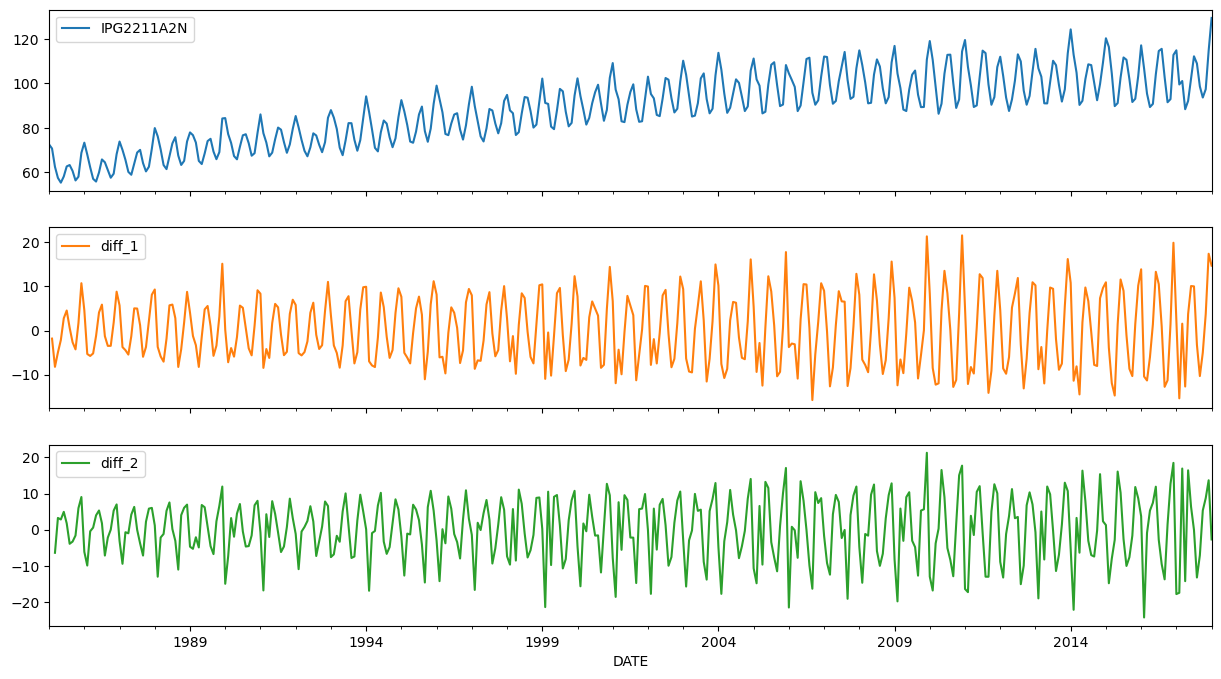

In [5]:
# first difference
ElectricProduction['diff_1'] = ElectricProduction['IPG2211A2N'].diff(1).dropna()
# second differece
ElectricProduction['diff_2'] = ElectricProduction['diff_1'].diff(1).dropna()
# plot figures
dfcheck = ElectricProduction.loc[:,['IPG2211A2N','diff_1','diff_2']]
dfcheck.plot(figsize = (15,8), subplots=True)

### Unit Root Test

According to the results of ADF test as follow, after the first difference，the p-value is less than 0.05 and Test Statistic is close to -7 less than the critical value in 1%、5%、10% confidence interval, it significantly reject the null hypotheis test, which means the process is stationary.

In [6]:
#original data
print(sm.tsa.stattools.adfuller(ElectricProduction['IPG2211A2N'].dropna()))
#the first difference
print(sm.tsa.stattools.adfuller(ElectricProduction['IPG2211A2N'].diff(1).dropna()))

(-2.2569903500472432, 0.18621469116586814, 15, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.8474501627156)
(-7.104890882267294, 4.077786565539826e-10, 14, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.5415092614144)


### White Noise Test-ljungbox test

The lb_pvalues are less than 0.05, rejecting the null hypothesis, thus it is not a white noise series. We can continue using this dataset to make prediction.

In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ElectricProduction['IPG2211A2N'].diff(1).dropna(), lags = [i for i in range(1,12)],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,55.971298,7.353678e-14,55.549404,9.113947e-14
2,129.405923,7.940738e-29,128.245992,1.418197e-28
3,378.015966,1.278543e-81,373.732793,1.082264e-80
4,443.342434,1.194202e-94,438.074441,1.643766e-93
5,503.147388,1.670635e-106,496.827548,3.863810e-105
6,734.213985,2.502536e-155,723.249590,5.837612e-153
7,796.099010,1.289117e-167,783.735206,5.999390e-165
8,861.169233,1.338230e-180,847.170499,1.396414e-177
9,1114.408671,3.608859e-234,1093.410857,1.224972e-229
10,1180.825606,1.969413e-247,1157.825271,1.797561e-242


### Build up ACF function and PACF function to find possible ARIMA models with estimated parameters(p,d=1,q). 
Note that autocorrelation has a regular period trend, and partial autocorrelation(PACF) "cut off" at lag 4, since most lags are not significant after lag 4.  We can guess AR(4) model or ARIMA model.

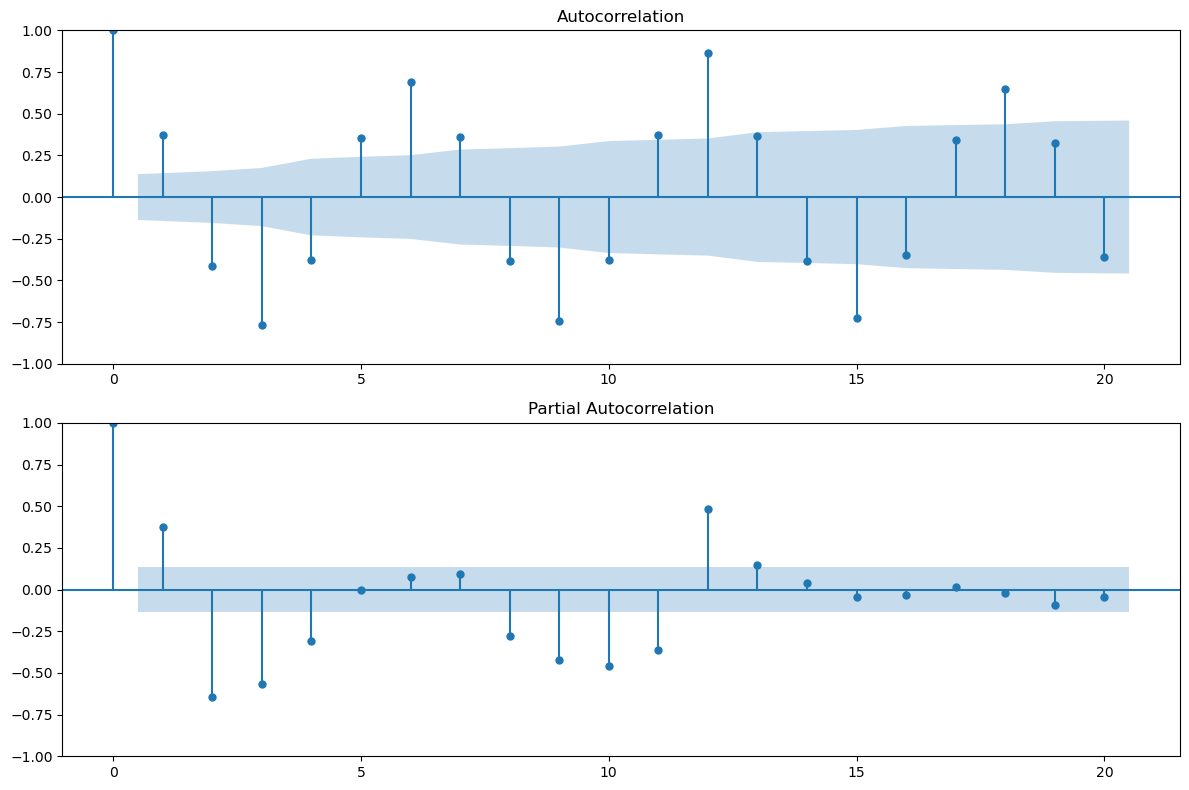

In [31]:
#ACF figure
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.diff(1).dropna(), lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()
 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.diff(1).dropna(), lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

## Fit the model

The process is to estimate parameters p,d,q for AR or ARIMA model:

In [41]:
#P,d=1,q
train_diff1 = train.diff(1).dropna()
arma_mod10 = sm.tsa.ARIMA(train_diff1,order = (1,1,0)).fit()
arma_mod40 = sm.tsa.ARIMA(train_diff1,order = (4,1,0)).fit()
arma_mod44 = sm.tsa.ARIMA(train_diff1,order = (4,1,4)).fit()
#AIC and BIC Test
values = [
    [arma_mod10.aic,arma_mod10.bic,arma_mod10.hqic],
    [arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic],
    [arma_mod44.aic,arma_mod44.bic,arma_mod44.hqic]
]
df = pd.DataFrame(values,index=["AR(1,1,0)","AR(4,1,0)","ARIMA(4,1,4)"],columns=["AIC","BIC","hqic"])
df


/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informa

,AIC,BIC,hqic
"AR(1,1,0)",1357.616159,1364.232694,1360.293221
"AR(4,1,0)",1175.771106,1192.312445,1182.463762
"ARIMA(4,1,4)",1068.821421,1098.595830,1080.868201


From above, we can see the results in the AIC and BIC test, so the best model might be ARIMA(p=4,d=1,q=4). Next, we move to check fitness of this model(significance of each coefficient, significance of the whole model).

In [42]:
print(arma_mod44.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  203
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -525.411
Date:                Sun, 13 Nov 2022   AIC                           1068.821
Time:                        10:51:51   BIC                           1098.596
Sample:                    02-01-1985   HQIC                          1080.868
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7343      0.042    -17.650      0.000      -0.816      -0.653
ar.L2         -0.1190      0.063     -1.877      0.061      -0.243       0.005
ar.L3         -0.4571      0.059     -7.686      0.0

In [38]:
print(arma_mod40.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  203
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -582.886
Date:                Sun, 13 Nov 2022   AIC                           1175.771
Time:                        10:48:48   BIC                           1192.312
Sample:                    02-01-1985   HQIC                          1182.464
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3591      0.049     -7.344      0.000      -0.455      -0.263
ar.L2         -0.4109      0.042     -9.766      0.000      -0.493      -0.328
ar.L3         -0.5923      0.050    -11.960      0.0

As we can see in AR(4) model, the coefficients with p-values all less than 0.05, they are significant to fit in model.

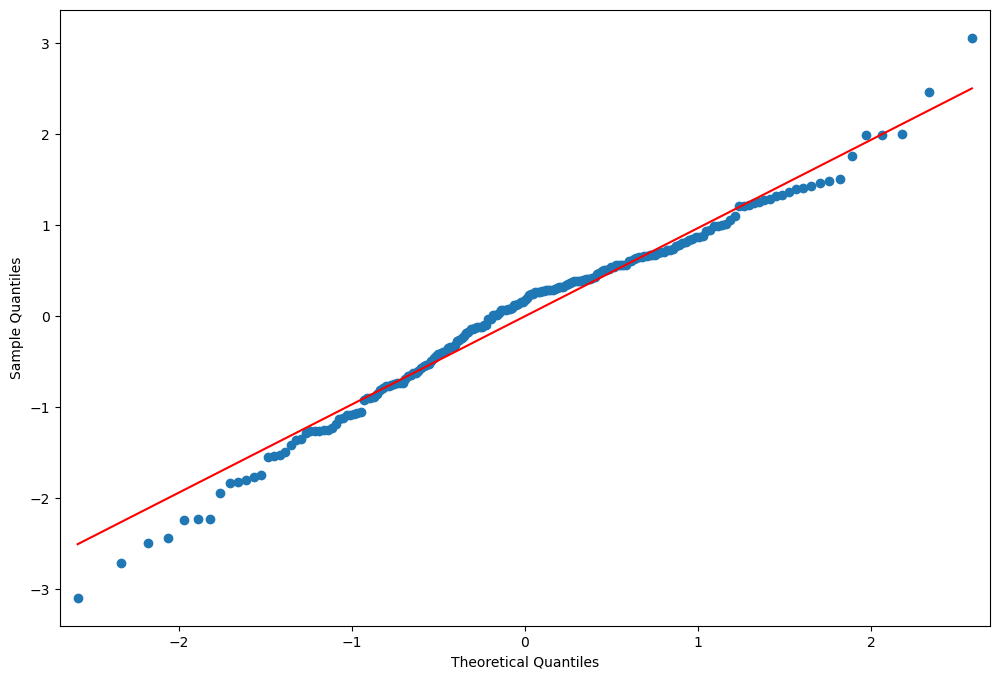

In [44]:
resid = arma_mod40.resid #the residual
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

<Figure size 1200x800 with 0 Axes>

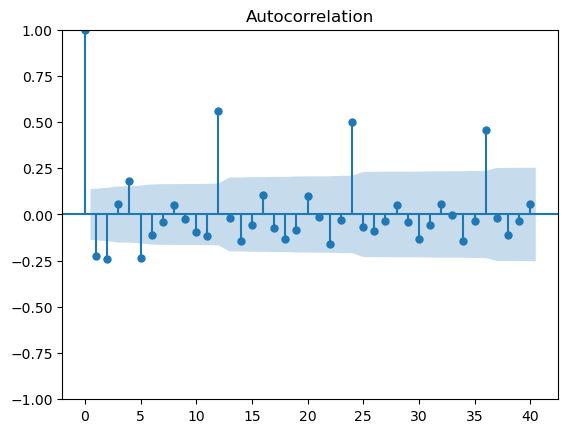

In [47]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)
plt.show()

As we can see, both qqplot (the plot of residuals is close to normal distribution) and the autocorrelation for residual illustrate the residual series meets requirements of white noise. Now, we can use this siginificant ARIMA(4,1,0) model, otherwise AR(4) with d=1 to predict results.

## Prediction
Use the model to predict values in any period where those vaules from dataset is used to build up this model or forcast values in the future.

/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/odile/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2014-01-01    118.175519
2014-02-01    117.435747
2014-03-01     98.105771
2014-04-01     97.562595
2014-05-01     94.996630
2014-06-01    107.565313
2014-07-01    111.431897
2014-08-01    109.627252
2014-09-01     99.683285
2014-10-01     93.193723
2014-11-01     93.256223
2014-12-01    106.988483
2015-01-01    113.193845
2015-02-01    115.716649
2015-03-01    103.671624
2015-04-01     96.927159
2015-05-01     92.459070
2015-06-01    105.123790
2015-07-01    114.195699
2015-08-01    112.191864
2015-09-01    100.419125
2015-10-01     93.092893
2015-11-01     92.227945
2015-12-01    102.284182
2016-01-01    111.167524
2016-02-01    116.081608
2016-03-01     95.229052
2016-04-01     89.039299
2016-05-01     93.355675
2016-06-01    103.542010
2016-07-01    111.021105
2016-08-01    110.336076
2016-09-01    103.733442
2016-10-01     91.640669
2016-11-01     92.301841
2016-12-01    103.607334
2017-01-01    122.750864
2017-02-01    110.333563
2017-03-01     88.754669
2017-04-01     97.883085


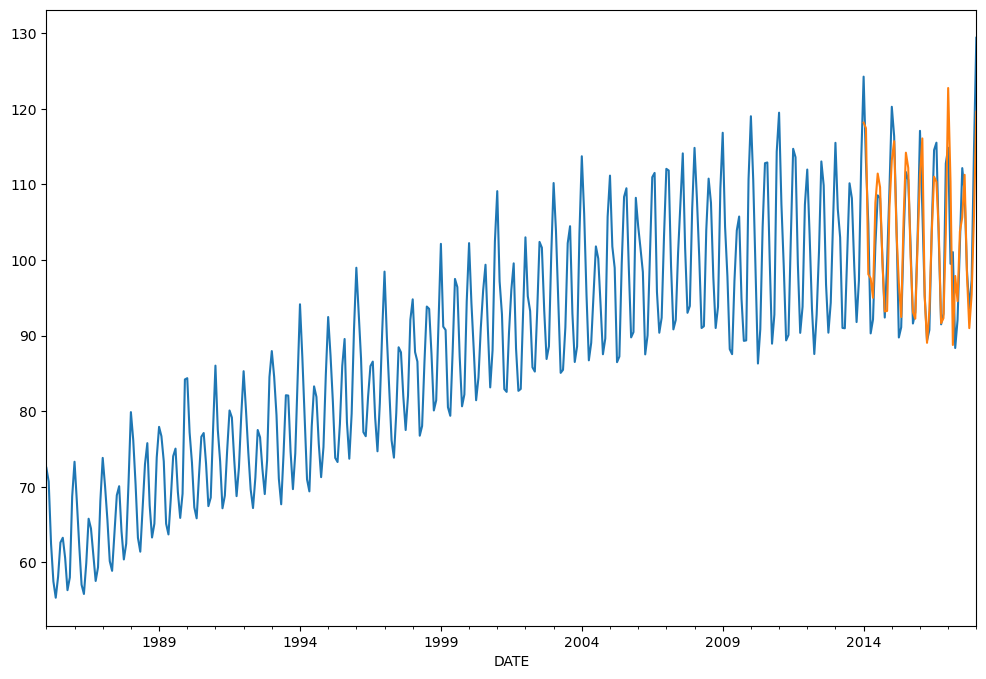

In [63]:
model = sm.tsa.ARIMA(data_EP, order=(4,1,0))
p_results = model.fit()
prediction = p_results.predict(start=str('2014'),end=str('2018'),dynamic=False)
print(prediction)
fig, ax = plt.subplots(figsize=(12, 8))
ax = data_EP.plot(ax=ax)
prediction.plot(ax=ax)
plt.show()

This prediction is an excellent fit to the trend. Then, We can do the future forecast.

In [64]:
#forecast the next value
p_results.forecast()[0]

121.67771893522952